In [218]:
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GAE
from torch_geometric.utils import to_dense_adj
from tqdm import trange

from datasets.SP100Stocks import SP100Stocks
from datasets.utils import get_stocks_labels
from notebooks.models import GCN

# Stocks clustering
The goal of this task is to cluster stocks based on their historical prices and the graph structure.

## Loading the data
The data from the custom PyG dataset for containing the historical prices and the graph structure of the stocks is loaded.

In [91]:
seq_len = 25
dataset = SP100Stocks(past_window=seq_len)
dataset, dataset[0]

(SP100Stocks(1209),
 Data(x=[100, 5, 25], edge_index=[2, 524], y=[100, 1], edge_weight=[524], close_price=[100, 25], close_price_y=[100, 1]))

In [92]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

## Temporal Convolutional Graph Autoencoder
The Temporal Convolutional Graph Autoencoder (TCGAE) is a model that combines the Graph Autoencoder (GAE) with a Convolutional Autoencoder (CAE) to encode the temporal graph data. The GAE is used to encode the graph structure of the stocks, while the CAE is used to encode the temporal information of the stocks using convolutional layers on the latent space of the GAE.

In [93]:
class CAE(nn.Module):
	"""
	Temporal convolutional autoencoder for temporal graph autoencoder.
	"""
	def __init__(self, in_channels: int, latent_dim: int, seq_len: int = 25):
		super(CAE, self).__init__()
		self.seq_len = seq_len
		self.encoder = nn.Sequential(
			nn.Conv1d(in_channels, latent_dim, 5, stride=3),
			nn.ReLU(),
			nn.Conv1d(latent_dim, latent_dim, 5, stride=3),
		)
		self.decoder = nn.Sequential(
			nn.ConvTranspose1d(latent_dim, latent_dim, 5, stride=2),
			nn.ReLU(),
			nn.ConvTranspose1d(latent_dim, latent_dim, 5, stride=2, padding=1),
			nn.ReLU(),
			nn.ConvTranspose1d(latent_dim, in_channels, 5, stride=2),
		)
		
	def encode(self, x: torch.tensor) -> torch.tensor:
		return self.encoder(x).squeeze(-1)
			
	def decode(self, z: torch.tensor) -> torch.tensor:
		return self.decoder(z.unsqueeze(-1))
			
	def loss(self, x: torch.tensor, z: torch.tensor) -> torch.tensor:
		return F.mse_loss(self.decode(z), x)
	
	def forward(self, x: torch.tensor) -> torch.tensor:
		return self.encode(x)

In [94]:
class TCGAE(nn.Module):
	def __init__(self, in_channels: int, latent_dim: int, seq_len: int = 25):
		super(TCGAE, self).__init__()
		self.seq_len = seq_len
		self.hidden_dim = latent_dim // 2
		self.latent_dim = latent_dim
		self.gae = GAE(
			GCN(in_channels, [self.hidden_dim, self.hidden_dim]),
		)
		self.cae = CAE(self.hidden_dim, latent_dim, seq_len)
			
	def loss(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		recon_loss = 0
		latent_seq = torch.zeros(x.shape[0], self.hidden_dim, self.seq_len)
		for i in range(self.seq_len):
			latent_seq[:, :, i] = self.gae.encode(x[:, :, i], edge_index, edge_weight)
			recon_loss += self.gae.recon_loss(latent_seq[:, :, i], edge_index,)
		return self.cae.loss(latent_seq, self.cae(latent_seq)) + recon_loss / self.seq_len
			
	def encode(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		latent_seq = torch.zeros(x.shape[0], self.hidden_dim, self.seq_len)
		for i in range(self.seq_len):
			latent_seq[:, :, i] = self.gae.encode(x[:, :, i], edge_index, edge_weight)
		return self.cae(latent_seq)
	
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		return self.encode(x, edge_index, edge_weight)

## Training
The model is trained using the Adam optimizer with a learning rate of 0.005 for 2 epochs.

In [216]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, dataloader: DataLoader, epochs: int):
	writer = SummaryWriter(f'runs/StocksClustering_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
	for epoch in (pbar := trange(epochs, desc='Epochs')):
		for i, data in enumerate(dataloader):
			optimizer.zero_grad()
			loss = model.loss(data.x, data.edge_index, data.edge_weight)
			loss.backward()
			optimizer.step()
			pbar.set_postfix({'Loss': loss.item(), 'Batch': f"{100*(i+1)/len(dataloader):.2f}%"})
			writer.add_scalar('Loss/Reconstruction Loss', loss.item(), epoch * len(dataloader) + i)

In [217]:
in_channels, latent_dim = dataset[0].x.shape[1], 16
lr, num_epochs = 0.005, 2

model = TCGAE(in_channels, latent_dim, seq_len)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

TCGAE(
  (gae): GAE(
    (encoder): GCN(
      (convs): ModuleList(
        (0): GCNConv(5, 8)
        (1): GCNConv(8, 8)
      )
    )
    (decoder): InnerProductDecoder()
  )
  (tcae): TCAutoencoder(
    (encoder): Sequential(
      (0): Conv1d(8, 16, kernel_size=(5,), stride=(3,))
      (1): ReLU()
      (2): Conv1d(16, 16, kernel_size=(5,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(2,))
      (1): ReLU()
      (2): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(2,), padding=(1,))
      (3): ReLU()
      (4): ConvTranspose1d(16, 8, kernel_size=(5,), stride=(2,))
    )
  )
)

In [97]:
train(model, optimizer, dataloader, num_epochs)

Epochs: 100%|██████████| 2/2 [12:23<00:00, 371.82s/it, Loss=1.27, Batch=100.00%]


## Results
We use the model to encode the stocks and cluster them using KMeans. We then plot the stocks in a 2D space using t-SNE.

### Clustering the stocks

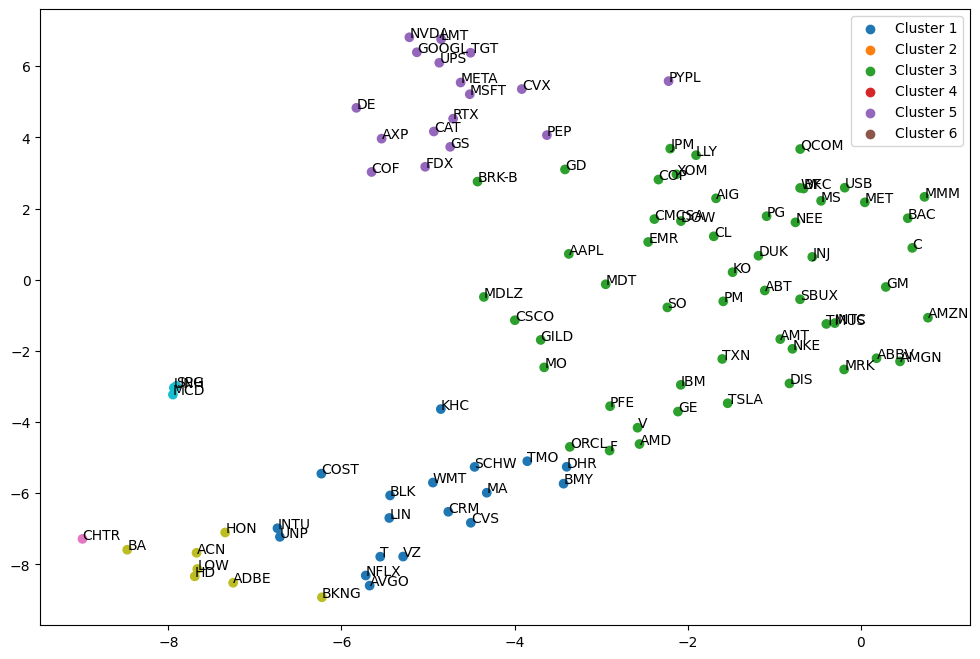

In [199]:
data = dataset[-1]
n_clusters = 6
labels = get_stocks_labels()

z = model(data.x, data.edge_index, data.edge_weight).detach().numpy()

z_embedded = TSNE(n_components=2).fit_transform(z)
cluster_labels = KMeans(n_clusters=n_clusters, random_state=0).fit(z).labels_

plt.figure(figsize=(12, 8))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=cluster_labels, cmap='tab10')
for i, label in enumerate(labels):
	plt.annotate(label, (z_embedded[i, 0], z_embedded[i, 1]))
	
for i in range(n_clusters):
	plt.scatter([], [], c=f"C{i}", label=f"Cluster {i+1}")
plt.legend()
plt.show()

### Stocks variations
The variations of the stocks in each cluster can be visualized. Note that the variation is not the only factor that determines the clustering, as the graph structure is also considered. There are still variations tendencies in each cluster.

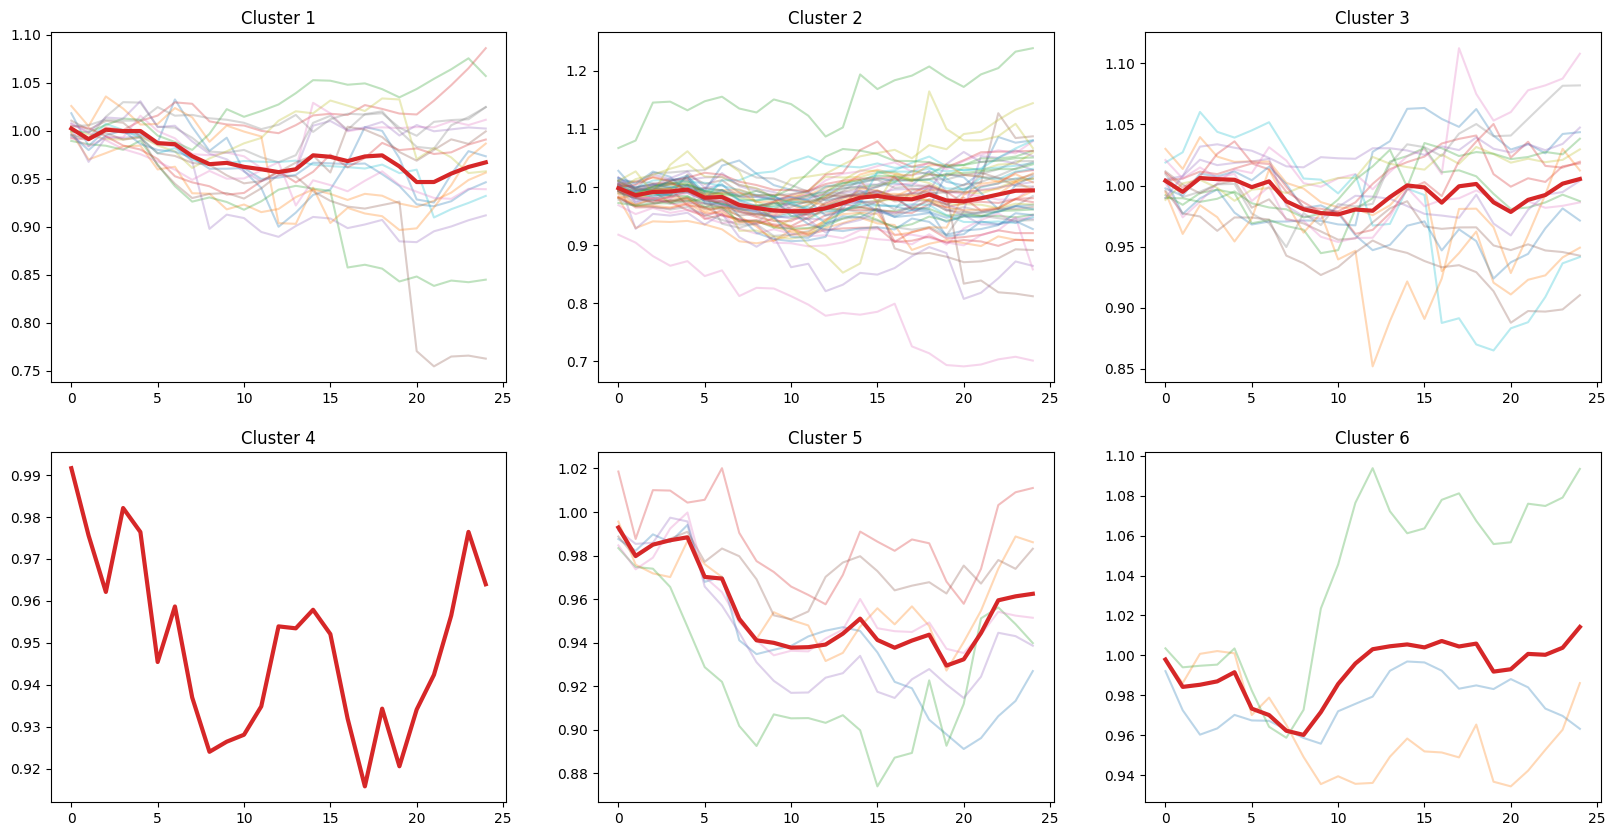

In [200]:
cols = 3
fig, axs = plt.subplots(2, cols, figsize=(20, 10))
for i in range(n_clusters):
	ax = axs[i//cols, i%cols]
	ax.set_title(f'Cluster {i+1}')
	cluster_variations = []
	for j in np.where(cluster_labels == i)[0]:
		variations = np.cumprod(1 + data.x[j, 2, :].detach().numpy() / 100, axis=0)
		cluster_variations.append(variations)
		ax.plot(variations, alpha=0.3)
		# ax.plot(data.x[j, 1, :])
	ax.plot(np.array(cluster_variations).transpose().mean(axis=1), linewidth=3, c="C3")
	# ax.set_yscale('log')
plt.show()

### Graph visualization
The graph structure of the stocks is visualized with the nodes colored by the cluster they belong to, for a more visual representation of the clustering.

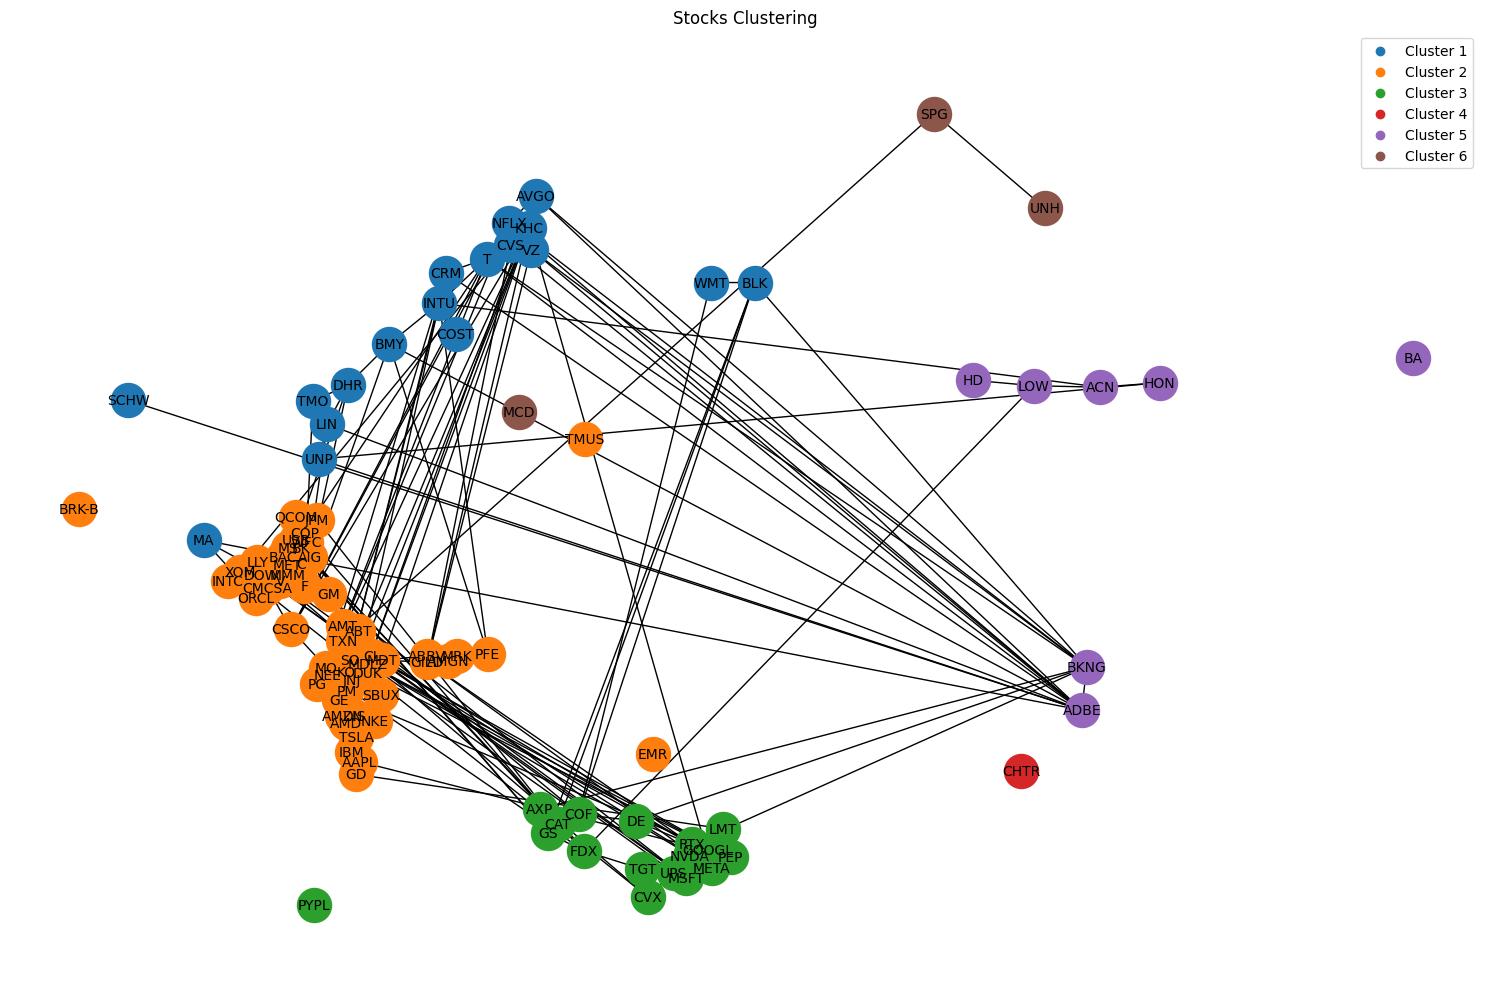

In [220]:
adj = to_dense_adj(data.edge_index)[0].detach().numpy()

plt.figure(figsize=(15, 10))
G = nx.from_numpy_array(adj)
G = nx.relabel_nodes(G, {i: label for i, label in enumerate(labels)})

communities = [
	set(
		label for stock_idx, label in enumerate(labels) if stock_idx in cluster
	) for cluster in [np.where(cluster_labels == i)[0] for i in range(n_clusters)]
]

centers = list(nx.spring_layout(nx.cycle_graph(len(communities)), scale=10).values())
pos = {}
for center, comm in zip(centers, communities):
    pos.update(nx.spring_layout(nx.subgraph(G, comm), center=center, scale=8))

# Nodes colored by cluster
for nodes, clr in zip(communities, (f"C{i}" for i in range(len(communities)))):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodes, node_color=clr, node_size=600)

nx.draw_networkx_labels(G, pos=pos, font_size=10, font_color='black')
nx.draw_networkx_edges(G, pos=pos)

for i in range(n_clusters):
	plt.scatter([], [], c=f"C{i}", label=f"Cluster {i+1}")
plt.legend()
plt.axis("off")
plt.title("Stocks Clustering")
plt.tight_layout()
plt.show()